## Feed Forward Network Predictions

In [ ]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks


conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = 8)
FFN_logs_base_dir='./Modellcheckpoints/FFn/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_FFN.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = highest_class +1 
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sdg_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks)

2025-06-18 12:19:33.614937: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<function DataConfig.__init__ at 0x77c7295a1940>
(self, bikes_path='.//data//bikes.csv', weather_path='.//data//weather.csv', highest_class=8)
/home/flo/python_projects/bike_forecast_kl/data_set_generator/data_config.py


/home/flo/python_projects/bike_forecast_kl/data_set_generator/bike_prediction.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station[key] = station[key]/station[key].max()
/home/flo/python_projects/bike_forecast_kl/data_set_generator/bike_prediction.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station[key] = station[key]/station[key].max()
/home/flo/python_projects/bike_forecast_kl/data_set_generator/bike_prediction.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

## Create Batch Generators

In [ ]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = False)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  1.         -0.62592347
    0.77988448]]

 [[ 0.77468936  0.54317987  0.         ...  1.         -0.99785892
    0.06540313]]

 [[ 0.77468837  0.54314303  0.         ...  1.          0.92387953
   -0.38268343]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.          0.85491187
    0.51877326]]

 [[ 0.77475748  0.54335612  0.         ...  1.          0.98836151
   -0.15212339]]

 [[ 0.7745871   0.54303512  0.         ...  0.          0.53729961
    0.84339145]]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Define and Create a FFN

In [3]:
model = keras.Sequential([keras.layers.Flatten(input_shape = (network_gen.history_length, x_batch.shape[-1])),
                keras.layers.Dense(4*input_dims+1, activation = 'relu',  kernel_initializer='he_normal'),
                keras.layers.Dense(4*input_dims+1, activation = 'relu',  kernel_initializer='he_normal'),
                keras.layers.Dense(output_dims, activation = 'softmax')]
        )
print(model.summary())

network_gen.register_network(model)
network_gen.model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,024 (11.81 KB)

 Trainable params: 3,024 (11.81 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.1943 - loss: 2.1805

/home/flo/python_projects/bike_forecast_kl/network_training/network_generator.py:91: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_batch[i][int(y_data.iloc[j])] = 1


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 108s 83ms/step - categorical_accuracy: 0.1945 - loss: 2.1802 - val_categorical_accuracy: 0.3505 - val_loss: 1.7496
Epoch 2/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3559 - loss: 1.7251

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - categorical_accuracy: 0.3559 - loss: 1.7250 - val_categorical_accuracy: 0.4052 - val_loss: 1.3878
Epoch 3/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.4729 - loss: 1.3533

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - categorical_accuracy: 0.4729 - loss: 1.3532 - val_categorical_accuracy: 0.5731 - val_loss: 1.1277
Epoch 4/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.6155 - loss: 1.0864

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - categorical_accuracy: 0.6156 - loss: 1.0863 - val_categorical_accuracy: 0.7009 - val_loss: 0.9247
Epoch 5/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.7477 - loss: 0.8821

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.7478 - loss: 0.8820 - val_categorical_accuracy: 0.8316 - val_loss: 0.7514
Epoch 6/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8377 - loss: 0.7107

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - categorical_accuracy: 0.8377 - loss: 0.7106 - val_categorical_accuracy: 0.8846 - val_loss: 0.6130
Epoch 7/25
1280/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8867 - loss: 0.5698

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - categorical_accuracy: 0.8868 - loss: 0.5697 - val_categorical_accuracy: 0.9144 - val_loss: 0.4867
Epoch 8/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9197 - loss: 0.4658

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - categorical_accuracy: 0.9197 - loss: 0.4657 - val_categorical_accuracy: 0.9233 - val_loss: 0.4089
Epoch 9/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9363 - loss: 0.3873

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.9363 - loss: 0.3873 - val_categorical_accuracy: 0.9440 - val_loss: 0.3554
Epoch 10/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9528 - loss: 0.3272

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.9528 - loss: 0.3272 - val_categorical_accuracy: 0.9429 - val_loss: 0.3184
Epoch 11/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9590 - loss: 0.2910

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - categorical_accuracy: 0.9590 - loss: 0.2910 - val_categorical_accuracy: 0.9515 - val_loss: 0.3000
Epoch 12/25
1280/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9665 - loss: 0.2586

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - categorical_accuracy: 0.9665 - loss: 0.2586 - val_categorical_accuracy: 0.9502 - val_loss: 0.2928
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - categorical_accuracy: 0.9682 - loss: 0.2392 - val_categorical_accuracy: 0.9524 - val_loss: 0.2933
Epoch 14/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - categorical_accuracy: 0.9689 - loss: 0.2364 - val_categorical_accuracy: 0.9523 - val_loss: 0.2981
Epoch 15/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.9690 - loss: 0.2322 - val_categorical_accuracy: 0.9524 - val_loss: 0.3059
Epoch 16/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.9692 - loss: 0.2284 - val_categorical_accuracy: 0.9530 - val_loss: 0.3136
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - categorical_accuracy: 0.9708 - loss: 0.2293 - val_categorical_accuracy: 0.9537 - val_loss: 0.3203
Epoch 18/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - categorical

## Print the Training Results

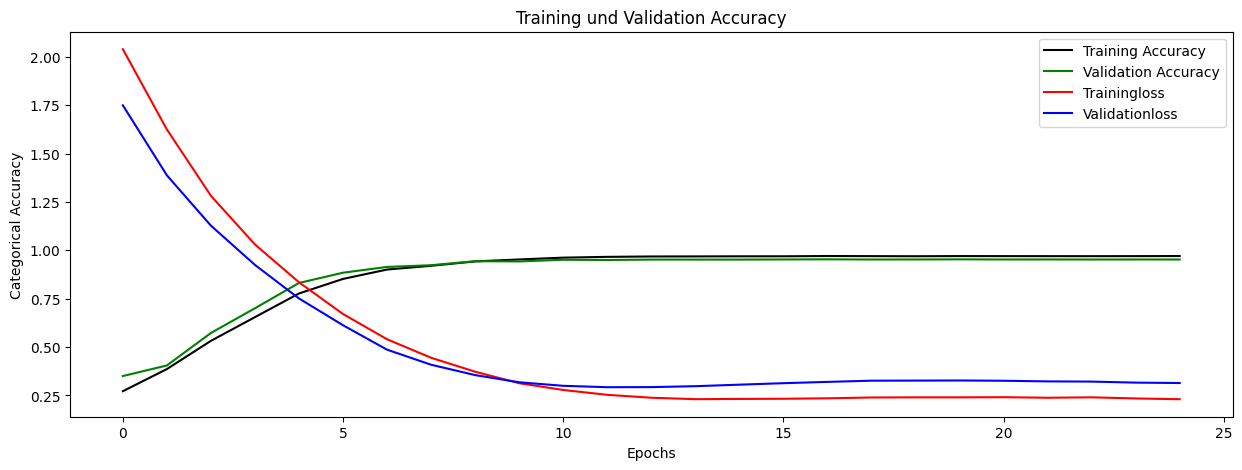

In [4]:
network_gen.print_training(results)

## Test Network and Generate Metrics

In [5]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,098 (47.26 KB)

 Trainable params: 3,024 (11.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,074 (35.45 KB)

17598/17598 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - categorical_accuracy: 0.9599 - loss: 0.2835
17598/17598 ━━━━━━━━━━━━━━━━━━━━ 12s 653us/step
Confusion Matrix
[[ 86775   1432    129     23      4      1      0      0      1]
 [  1413  72703   1490    142     17      3      3      0      0]
 [   105   1435  60198   1361    141     22      4      0      0]
 [    30    132   1307  51545   1166    121     19      7      6]
 [    13     24     99   1119  43083   1263    109     21     21]
 [     7     15     19    105   1081  34318   1360    111     32]
 [    10      9     16     22    112    968  28764    883    141]
 [     0      5      1      9     15     72    896  27404    880]
 [     9     14      9      9     14     25    112    885 137286]]
Klassifikations Report
0.9626552774349366
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     88365
           1       0.96      0.96      0.96     75771
           2